In [1]:
import torch as t
from torch import nn
import numpy as np
from tqdm.notebook import tqdm
# import torchopt
import functorch
from functools import partial
from torch.utils.data import DataLoader, Dataset, RandomSampler
from jaxtyping import Float, Int
from typing import Tuple, List, Dict, Any


import os, sys
# HOME = os.environ['HOME']  # change if necessary
HOME = '/workspace/wilson'
sys.path.append(f'{HOME}/Finite-groups/src')
from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from train import Parameters
from functools import partial, reduce
%load_ext autoreload
%autoreload 2

In [2]:
def flatten(
    params: Dict[str, t.Tensor]
) -> Tuple[t.Tensor, Dict[str, t.Size]]:
    return t.cat([p.flatten() for p in params.values()]), {k: p.size() for k, p in params.items()}

def unflatten(
    flat_params: t.Tensor, 
    shapes: Dict[str, t.Size],
) -> Dict[str, t.Tensor]:
    params = dict()
    for name, shape in shapes.items():
        size = np.prod(shape)
        params[name] = flat_params[:size].reshape(shape)
        flat_params = flat_params[size:]
    return params

In [3]:
def jac_compose(fs: List[Callable], x: Float[t.Tensor, 'n'], stride=10) -> Float[t.Tensor, 'n n']:
    '''
    Returns Jacobian of composition of fs (left to right) at x using iterated jacfwd calls
    '''
    prod_jac = t.eye(x.size(0), device=device)
    prod_jacs = []
    for i, f in enumerate(tqdm(fs)):
        cur_jac = t.func.jacfwd(f)(x).detach()
        with t.no_grad():
            prod_jac = cur_jac @ prod_jac
            x = f(x).detach()
            if i % stride == 0:
                prod_jacs.append(prod_jac)
                prod_jac = t.eye(x.size(0), device=device)
    prod_jacs.append(prod_jac)
    return prod_jacs

In [4]:
def get_adam_step(loss_func, i, cfg: Parameters):
    lr = cfg.lr
    betas = (cfg.beta1, cfg.beta2)
    eps = 1e-8
    weight_decay = cfg.weight_decay
    def adam_step(state):
        # state is cat([flat_params, m, v])
        assert state.shape[0] % 3 == 0
        flat_params, m, v = state.chunk(3)
        g = t.func.grad(loss_func)(flat_params)
        g += weight_decay * flat_params
        m = betas[0] * m + (1 - betas[0]) * g
        v = betas[1] * v + (1 - betas[1]) * g**2
        m_hat = m / (1 - betas[0]**(i+1))
        v_hat = v / (1 - betas[1]**(i+1))
        flat_params = flat_params - lr * m_hat / (t.sqrt(v_hat) + eps)
        return t.cat([flat_params, m, v])

    return adam_step

In [5]:
def train_adam(flat_params: t.Tensor, loss_func: Callable, epochs: int, cfg: Parameters) -> t.Tensor:
    state = t.cat([flat_params, t.zeros_like(flat_params), t.zeros_like(flat_params)])
    for i in tqdm(range(epochs)):
        # import gc; gc.collect()
        # t.cuda.empty_cache()
        adam_step = get_adam_step(loss_func, i, cfg)
        state = adam_step(state)
        # No need to differentiate through state
        # We'll do it manually with jac_compose
        state = state.detach()
    # for i in tqdm(range(epochs)):
    #     g = t.func.grad(loss_func)(flat_params)
    #     g += weight_decay * flat_params
    #     m = betas[0] * m + (1 - betas[0]) * g
    #     v = betas[1] * v + (1 - betas[1]) * g**2
    #     m_hat = m / (1 - betas[0]**(i+1))
    #     v_hat = v / (1 - betas[1]**(i+1))
    #     flat_params = flat_params - lr * m_hat / (t.sqrt(v_hat) + eps)
    flat_params, _, _ = state.chunk(3)
    return flat_params

### Quadratic toy example

In [13]:
class QuadraticModel(nn.Module):
    def __init__(self, A):
        super().__init__()
        self.A = A
        self.x = nn.Parameter(t.randn(A.shape[0]))

    def forward(self):
        return (self.x.T @ self.A @ self.x).squeeze()


# B = t.randn(5, 5)
# model = QuadraticModel(B.T @ B + 0.01 * t.eye(5))
model = QuadraticModel(t.eye(1000).to(device)).to(device)
# opt = torchopt.FuncOptimizer(torchopt.adam(**ADAM_CFG))
# model_f, init_params = functorch.make_functional(model)
flat_init_params, shapes = flatten(dict(model.named_parameters()))
loss_func = lambda flat_params, model=model, shapes=shapes: t.func.functional_call(model, unflatten(flat_params, shapes), ())

In [14]:
train_adam(flat_init_params, loss_func, 1000)

TypeError: train_adam() missing 1 required positional argument: 'cfg'

In [38]:
t.func.jacfwd(partial(train_adam, loss_func=loss_func, epochs=10))(flat_init_params)

100%|██████████| 10/10 [00:00<00:00, 173.87it/s]


tensor([[0.9998, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9999, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9999, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9998, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9553]], grad_fn=<ViewBackward0>)

In [5]:
t.cuda.memory._record_memory_history(max_entries=100000)
train_jac = t.func.jacfwd(partial(train_adam, loss_func=loss_func, epochs=1000))(flat_init_params)
t.cuda.memory._dump_snapshot('/workspace/memory_snapshot_toy.pkl')
t.cuda.memory._record_memory_history(enabled=None)

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_22897/635461659.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return (self.x.T @ self.A @ self.x).squeeze()
100%|██████████| 1000/1000 [00:16<00:00, 61.98it/s]


### Groups

In [6]:
PARAMS = Parameters(
    instances=1,
    embed_dim=32,
    hidden_size=32,
    # group_string='S(4)',
    group_string='S(4);times(A(4),Z(2))',
    # embed_dim=128,
    # hidden_size=128,
    # group_string='S(5)',
    model='MLP2',
    unembed_bias=True,
    weight_decay=2e-4,
    # train_frac=0.6,
    train_frac=1.0,
    seed=0,
)

t.manual_seed(PARAMS.seed)
np.random.seed(PARAMS.seed)
random.seed(PARAMS.seed)
group_dataset = GroupData(params=PARAMS)
model = MODEL_DICT[PARAMS.model](params=PARAMS).to(device)
train_dataset = t.tensor(group_dataset.train_data, device=device)
test_x = t.tensor(list(product(range(group_dataset.N), repeat=2)), device=device)
test_z = einops.rearrange(group_dataset.groups[0].cayley_table, "a b -> (a b) 1").to(device)
test_dataset = t.cat([test_x, test_z], dim=1)

flat_init_params, shapes = flatten(dict(model.named_parameters()))
def loss_func(flat_params, model=model, shapes=shapes, dataset=train_dataset):
    x, z = dataset[:, :-1], dataset[:, -1]
    output = t.func.functional_call(model, unflatten(flat_params, shapes), x)
    return get_cross_entropy(output, z).squeeze()

Intersection size: 336/576 (0.58)
Added 336 elements from intersection
Added 0 elements from group 0: S(4)
Added 0 elements from group 1: times(A(4),Z(2))
Train set size: 336/576 (0.58)


In [7]:
flat_params = train_adam(flat_init_params, loss_func, 4000, PARAMS)
loss_func(flat_params, dataset=train_dataset).item(), loss_func(flat_params, dataset=test_dataset).item()

  0%|          | 0/4000 [00:00<?, ?it/s]

 10%|▉         | 388/4000 [00:03<00:28, 128.68it/s]


KeyboardInterrupt: 

In [9]:
adam_steps = [
    get_adam_step(loss_func, i, PARAMS) for i in range(4000)
]
train_jac = jac_compose(adam_steps, t.cat([flat_init_params, t.zeros_like(flat_init_params), t.zeros_like(flat_init_params)]), stride=100)

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [22:11<00:00,  3.01it/s]


In [11]:
# t.save(train_jac, '/workspace/wilson/Finite-groups/data/train_jac_prods_S4_stride100.pt')
t.save(train_jac, '/workspace/wilson/Finite-groups/data/train_jac_prods_S4_A4_2_stride100.pt')

In [ ]:
# train_jac = t.load('/workspace/wilson/Finite-groups/data/train_jac_prods_S4_stride100.pt')
train_jac = t.load('/workspace/wilson/Finite-groups/data/train_jac_prods_S4_A4_2_stride100.pt')

/tmp/ipykernel_84392/227421671.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_jac = t.load('/workspace/wilson/Finite-groups/data/train_jac_prods_S4_A4_2_stride100

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/wilson/Finite-groups/data/train_jac_prods_S4_A4_2_stride100.pt'

In [13]:
jac1 = reduce(t.matmul, t.load('/workspace/wilson/Finite-groups/data/train_jac_prods_S4_stride100.pt')[:20])
jac2 = reduce(t.matmul, t.load('/workspace/wilson/Finite-groups/data/train_jac_prods_S4_A4_2_stride100.pt')[:20])

/tmp/ipykernel_92206/2655443496.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  jac1 = reduce(t.matmul, t.load('/workspace/wilson/Finite-groups/data/train_jac_prods_S4_s

In [ ]:
# train_jac = [jac[:flat_init_params.shape[0], :flat_init_params.shape[0]] for jac in train_jac]

In [8]:
nparams = flat_init_params.size(0)
norms = [t.linalg.matrix_norm(jac[:nparams, :nparams], ord=2).item() for jac in tqdm(train_jac)]

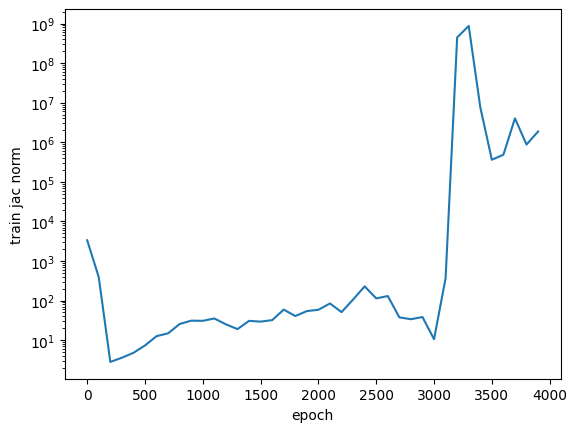

In [12]:
plt.plot(range(0, 4000, 100), norms)
plt.yscale('log')
plt.ylabel('train jac norm')
plt.xlabel('epoch')
plt.show()

In [13]:
cum_jac = t.eye(train_jac[0].shape[0], device=device)
cum_norms = []
for jac in tqdm(train_jac):
    cum_jac = jac @ cum_jac
    cum_norms.append(t.linalg.matrix_norm(cum_jac[:nparams, :nparams], ord=2).item())

 88%|████████▊ | 35/40 [09:14<01:19, 15.84s/it]


KeyboardInterrupt: 

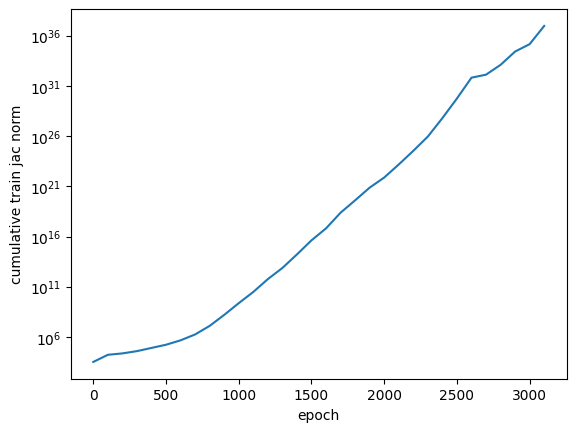

In [15]:
plt.plot(list(range(0, 4000, 100))[:len(cum_norms)], cum_norms)
plt.yscale('log')
plt.ylabel('cumulative train jac norm')
plt.xlabel('epoch')
plt.show()

In [14]:
# U, S, V = t.svd(train_jac[0])
S1 = t.linalg.svdvals(jac1[:nparams, :nparams])
S2 = t.linalg.svdvals(jac2[:nparams, :nparams])


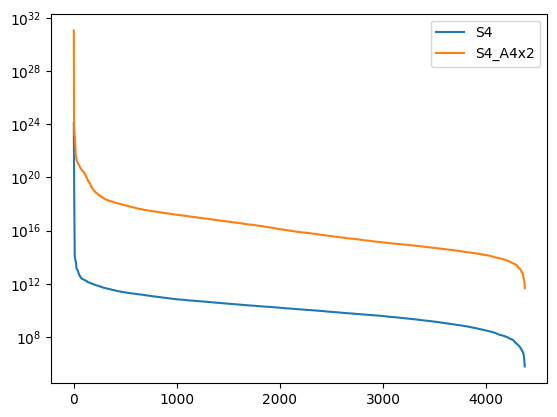

In [16]:
plt.plot(S1.detach().cpu().numpy()[:], label='S4')
plt.plot(S2.detach().cpu().numpy()[:], label='S4_A4x2')
plt.axhline(1, linestyle='--', c='k', alpha=0.3)
plt.yscale('log')
plt.legend()
plt.show()